### D7041-Lab 2

In [ ]:
"""
D7041-Lab 2
Deborah Aittoklllio debait-2
Joel Willén Joewil-2

"""

### Part 1: Language Classification with High-Dimensional Distributed Representations


#### Task 1.1: Import Datasets


In [10]:
# Import necessary libraries
import numpy as np              # For numerical operations and arrays
import os                        # For file and folder operations
import re                        # For text cleaning (remove punctuation)
from collections import defaultdict  # For storing data in dictionaries
import glob                      # For finding files with patterns

In [11]:
# Define the path to my language data folder
data_folder = r"C:\Users\Deborah Aittokallio\OneDrive - ltu.se\University Courses\Applied Artificial Intelligence D7041E (CURRENT)\Labs\Lab 2\lab2_HD_SOM_BACKPROP\lab2_HD_SOM_BACKPROP\News_Languages"

# Check if the folder exists
print("Checking folder contents...")
print(f"Folder path: {data_folder}")
print(f"Folder exists: {os.path.exists(data_folder)}")
print(f"Is it a directory: {os.path.isdir(data_folder)}")

# List all files and folders in the directory
if os.path.exists(data_folder):
    all_items = os.listdir(data_folder)
    print(f"\nTotal items found: {len(all_items)}")
    print("\nFirst 20 items:")
    for i, item in enumerate(all_items[:20]):
        full_path = os.path.join(data_folder, item)
        item_type = "FOLDER" if os.path.isdir(full_path) else "FILE"
        print(f"  [{item_type}] {item}")

Checking folder contents...
Folder path: C:\Users\Deborah Aittokallio\OneDrive - ltu.se\University Courses\Applied Artificial Intelligence D7041E (CURRENT)\Labs\Lab 2\lab2_HD_SOM_BACKPROP\lab2_HD_SOM_BACKPROP\News_Languages
Folder exists: True
Is it a directory: True

Total items found: 21

First 20 items:
  [FOLDER] bul_news_2020_100K
  [FOLDER] ces_news_2020_100K
  [FOLDER] dan_news_2020_100K
  [FOLDER] deu_news_2020_100K
  [FOLDER] ell_news_2020_100K
  [FOLDER] eng_news_2020_100K
  [FOLDER] est_news_2020_100K
  [FOLDER] fin_news_2020_100K
  [FOLDER] fra_news_2020_100K
  [FOLDER] hun_news_2020_100K
  [FOLDER] ita_news_2020_100K
  [FOLDER] lav_news_2020_100K
  [FOLDER] lit_news_2020_100K
  [FOLDER] nld_news_2020_100K
  [FOLDER] pol_news_2020_100K
  [FOLDER] por_news_2020_100K
  [FOLDER] ron_news_2020_100K
  [FOLDER] slk_news_2020_100K
  [FOLDER] slv_news_2020_100K
  [FOLDER] spa_news_2020_100K


In [12]:
# Function to load text from a file
def load_text_file(file_path):
    """
    Read text from a file
    Input: file path (string)
    Output: text content (string)
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        return text
    except:
        # If UTF-8 doesn't work, try latin-1 encoding
        with open(file_path, 'r', encoding='latin-1') as f:
            text = f.read()
        return 
    



In [13]:
# Function to clean text (remove punctuation and extra spaces)
def clean_text(text):
    """
    Remove punctuation and convert to lowercase
    Input: raw text (string)
    Output: cleaned text (string)
    """
    # Convert to lowercase
    text = text.lower()
    
    # Keep only letters and spaces (remove punctuation, numbers, etc.)
    text = re.sub(r'[^a-zäöüßàáâãäåæçèéêëìíîïñòóôõöøùúûüýÿ\s]', '', text)
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing spaces
    text = text.strip()
    
    return text

In [17]:
def load_language_data_from_nested_subfolders(base_folder):
    """
    Load all language text files from nested subfolders
    Input: base folder path (string)
    Output: dictionary with language names as keys and text as values
    """
    language_data = {}  # Create empty dictionary to store data
    
    # Get all subfolders in the base folder
    subfolders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
    
    print(f"Found {len(subfolders)} language folders")
    
    # Loop through each language subfolder
    for subfolder in subfolders:
        # Extract language code (first 3 letters: bul, eng, fra, etc.)
        language_code = subfolder[:3]
        
        # Path to the language folder
        lang_folder_path = os.path.join(base_folder, subfolder)
        
        # Check if there's a nested folder with the same name
        nested_folder_path = os.path.join(lang_folder_path, subfolder)
        
        # Use nested folder if it exists, otherwise use the main folder
        if os.path.isdir(nested_folder_path):
            search_path = nested_folder_path
        else:
            search_path = lang_folder_path
        
        # Find all .txt files in the search path
        txt_files = glob.glob(os.path.join(search_path, "*.txt"))
        
        if len(txt_files) == 0:
            print(f"  ⚠ {language_code}: No .txt files found in {subfolder}")
            continue
        
        # We'll use the "sentences.txt" file if it exists (cleanest data)
        # Otherwise combine all .txt files
        sentences_file = os.path.join(search_path, f"{subfolder}-sentences.txt")
        
        if os.path.exists(sentences_file):
            # Use only the sentences file (best for language classification)
            text = load_text_file(sentences_file)
            cleaned_text = clean_text(text)
            print(f"  ✓ {language_code}: Loaded sentences file, {len(cleaned_text)} characters")
        else:
            # Combine all text files for this language
            all_text = ""
            for txt_file in txt_files:
                text = load_text_file(txt_file)
                all_text += text + " "  # Add space between files
            
            cleaned_text = clean_text(all_text)
            print(f"  ✓ {language_code}: Loaded {len(txt_files)} file(s), {len(cleaned_text)} characters")
        
        # Store in dictionary
        language_data[language_code] = cleaned_text
    
    return language_data




In [18]:
# Function to split text into training, validation, and test sets
def split_data(text, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Split text into train/val/test portions"""
    # Calculate split points based on text length
    total_length = len(text)
    train_end = int(total_length * train_ratio)
    val_end = train_end + int(total_length * val_ratio)
    
    # Split the text
    train_text = text[:train_end]
    val_text = text[train_end:val_end]
    test_text = text[val_end:]
    
    return train_text, val_text, test_text

print("✓ split_data function defined")

✓ split_data function defined


In [19]:
# Load all language data from nested subfolders
print("Loading language data from nested subfolders...")
language_texts = load_language_data_from_nested_subfolders(data_folder)
print(f"\n✓ Total languages loaded: {len(language_texts)}")
print(f"Languages: {sorted(list(language_texts.keys()))}")

# Split each language's data into train/val/test
train_data = {}  # Dictionary to store training data for each language
val_data = {}    # Dictionary to store validation data for each language
test_data = {}   # Dictionary to store test data for each language

print("\nSplitting data into train/validation/test sets (70%/15%/15%)...")

for language, text in language_texts.items():
    # Split the text for this language
    train_text, val_text, test_text = split_data(text)
    
    # Store the splits
    train_data[language] = train_text
    val_data[language] = val_text
    test_data[language] = test_text
    
    print(f"  {language}: Train={len(train_text)} | Val={len(val_text)} | Test={len(test_text)} characters")

print("\n✓ Data loading and splitting complete!")

Loading language data from nested subfolders...
Found 21 language folders
  ✓ bul: Loaded sentences file, 39908 characters
  ✓ ces: Loaded sentences file, 8541308 characters
  ✓ dan: Loaded sentences file, 10426448 characters
  ✓ deu: Loaded sentences file, 10360606 characters
  ✓ ell: Loaded sentences file, 180880 characters
  ✓ eng: Loaded sentences file, 11234400 characters
  ✓ est: Loaded sentences file, 10606005 characters
  ✓ fin: Loaded sentences file, 9620216 characters
  ✓ fra: Loaded sentences file, 11535536 characters
  ✓ hun: Loaded sentences file, 11758448 characters
  ✓ ita: Loaded sentences file, 11654444 characters
  ✓ lav: Loaded sentences file, 10856836 characters
  ✓ lit: Loaded sentences file, 9894916 characters
  ✓ nld: Loaded sentences file, 8593819 characters
  ✓ pol: Loaded sentences file, 8804624 characters
  ✓ por: Loaded sentences file, 11499232 characters
  ✓ ron: Loaded sentences file, 10705686 characters
  ✓ slk: Loaded sentences file, 9667070 characters
 

In [20]:
# Display a sample from one language to verify
sample_language = sorted(list(train_data.keys()))[0]  # Get first language alphabetically
print(f"\nSample from '{sample_language}' training data (first 200 characters):")
print(train_data[sample_language][:200])


Sample from 'bul' training data (first 200 characters):
kritikar aaaa abbvie astrazeneca aci iata adobe magento leader magic quadrant gartner it airbnb ako ako allianz amazon anna koleva kadirova anthrax spreading the disease accept pandemic anton petrov a


In [ ]:
# TODO:


"""Import libraries (numpy, os, re, etc.) ✓
Load News Wortschatz Corpora ✓
Load Euro Parliament Parallel Corpus
Preprocess data (remove punctuation, etc.) ✓
"""

#### Task 1.2: Constructing High-Dimensional Centroids


In [ ]:
# TODO:

"""
Implement n-gram encoding (n=3, tri-grams) 
Create HD vectors with d=100 and d=1000
Build language centroids (21 languages)
Answer questions about conventional n-gram representations
"""

In [ ]:

print("TASK 1.2: Constructing High-Dimensional Centroids")

# Step 1: Function to make random HD vectors
def create_random_hd_vector(dimension, seed=None):
    """Make a random vector with only +1 or -1 values"""
    if seed is not None:
        np.random.seed(seed)  # Use seed so we get same vector each time
    
    # Pick randomly between +1 and -1 for each position
    vector = np.random.choice([1, -1], size=dimension)
    return vector

# Test it with a small example
test_vec = create_random_hd_vector(10, seed=42)
print(f"Example 10D vector: {test_vec}")

# Step 2: Get tri-grams from text

def get_trigrams(text, n=3):
    """Split text into tri-grams (3-letter chunks)"""
    trigrams = []
    
    # Go through text and grab 3 letters at a time
    for i in range(len(text) - n + 1):
        chunk = text[i:i+n]  # Get 3 letters
        trigrams.append(chunk)
    
    return trigrams

# Test with example
sample = "hello world"
print(f"\nTri-grams from '{sample}':")
print(get_trigrams(sample, n=3))

# Step 3: Make a dictionary with HD vectors for each tri-

def make_trigram_dictionary(all_texts, dimension, n=3):
    """Create HD vectors for all unique tri-grams we find"""
    trigram_to_vector = {}  # Store tri-gram -> vector mapping
    count = 0
    
    print(f"Making tri-gram dictionary (dimension={dimension})...")
    
    # Look through all training texts
    for text in all_texts:
        # Get all tri-grams
        trigrams = get_trigrams(text, n=n)
        
        # For each tri-gram, make a vector if we haven't seen it yet
        for tg in trigrams:
            if tg not in trigram_to_vector:
                # Make new HD vector for this tri-gram
                seed = hash(tg) % (2**31)  # Use hash as seed
                trigram_to_vector[tg] = create_random_hd_vector(dimension, seed=seed)
                count += 1
    
    print(f"Found {count} unique tri-grams")
    return trigram_to_vector

# Make dictionaries for both dimensions
print("\nBuilding for d=100...")
trigram_dict_100 = make_trigram_dictionary(list(train_data.values()), dimension=100, n=3)

print("\nBuilding for d=1000...")
trigram_dict_1000 = make_trigram_dictionary(list(train_data.values()), dimension=1000, n=3)
# Step 4: Turn a text into one HD vector
def text_to_hd_vector(text, trigram_dict, n=3):
    """Convert text to HD vector by adding up all tri-gram vectors"""
    
    # Get dimension size
    dimension = len(list(trigram_dict.values())[0])
    
    # Start with all zeros
    result_vector = np.zeros(dimension)
    
    # Get all tri-grams from text
    trigrams = get_trigrams(text, n=n)
    
    # Add up the vectors for each tri-gram
    for tg in trigrams:
        if tg in trigram_dict:
            result_vector = result_vector + trigram_dict[tg]
    
    return result_vector

# Test it
test_text = list(train_data.values())[0][:100]
test_vector = text_to_hd_vector(test_text, trigram_dict_100, n=3)
print(f"\nEncoded sample text to {len(test_vector)}D vector")
print(f"First 10 values: {test_vector[:10]}")
# Step 5: Make one HD vector (centroid) for each language
def make_language_centroids(language_texts, trigram_dict, n=3):
    """Create centroid vector for each language"""
    
    centroids = {}
    dimension = len(list(trigram_dict.values())[0])
    
    print(f"\nMaking centroids (d={dimension})...")
    
    # For each language
    for lang, text in language_texts.items():
        # Turn all the text into one HD vector
        centroid = text_to_hd_vector(text, trigram_dict, n=n)
        centroids[lang] = centroid
        
        print(f"  {lang}: done")
    
    return centroids

# Make centroids for both dimensions
print("="*60)
print("Creating centroids with d=100")
print("="*60)
centroids_100 = make_language_centroids(train_data, trigram_dict_100, n=3)

print("\n" + "="*60)
print("Creating centroids with d=1000")
print("="*60)
centroids_1000 = make_language_centroids(train_data, trigram_dict_1000, n=3)

print(f"\nDone! Created centroids for {len(centroids_100)} languages")

# Summary
print("\n" + "="*60)
print("TASK 1.2 DONE")
print("="*60)
print(f"Unique tri-grams found: {len(trigram_dict_100)}")
print(f"Languages: {len(centroids_100)}")
print(f"Dimensions tested: 100 and 1000")

TASK 1.2: Constructing High-Dimensional Centroids
Example 10D vector: [ 1 -1  1  1  1 -1  1  1  1 -1]

Tri-grams from 'hello world':
['hel', 'ell', 'llo', 'lo ', 'o w', ' wo', 'wor', 'orl', 'rld']

Building for d=100...
Making tri-gram dictionary (dimension=100)...
Found 40121 unique tri-grams

Building for d=1000...
Making tri-gram dictionary (dimension=1000)...
Found 40121 unique tri-grams

Encoded sample text to 100D vector
First 10 values: [ -2.  12. -28. -18.   0. -14. -16.  10.   8.   4.]
Creating centroids with d=100

Making centroids (d=100)...
  bul: done
  ces: done
  dan: done
  deu: done
  ell: done
  eng: done
  est: done
  fin: done
  fra: done
  hun: done
  ita: done
  lav: done
  lit: done
  nld: done
  pol: done
  por: done
  ron: done
  slk: done
  slv: done
  spa: done
  swe: done

Creating centroids with d=1000

Making centroids (d=1000)...
  bul: done
  ces: done
  dan: done
  deu: done
  ell: done
  eng: done
  est: done
  fin: done
  fra: done
  hun: done
  ita: 

#### Task 1.3: Classification using Hyperdimensional Centroids


TASK 1.3: Classification with HD Centroids
Example cosine similarity: 0.9800

Test classification: Predicted = bul
Top 3 similarities: [('bul', np.float64(0.5880479903595789)), ('ell', np.float64(0.4506167002555526)), ('slk', np.float64(0.3307829870512226))]
Evaluating with d=100

Evaluating on Validation set...
  ✓ bul -> bul
  ✓ ces -> ces
  ✓ dan -> dan
  ✓ deu -> deu
  ✓ ell -> ell
  ✓ eng -> eng
  ✓ est -> est
  ✓ fin -> fin
  ✓ fra -> fra
  ✓ hun -> hun
  ✓ ita -> ita
  ✓ lav -> lav
  ✓ lit -> lit
  ✓ nld -> nld
  ✓ pol -> pol
  ✓ por -> por
  ✓ ron -> ron
  ✓ slk -> slk
  ✓ slv -> slv
  ✓ spa -> spa
  ✓ swe -> swe
Results with d=100:
Accuracy: 1.0000 (100.00%)
F1-Score: 1.0000


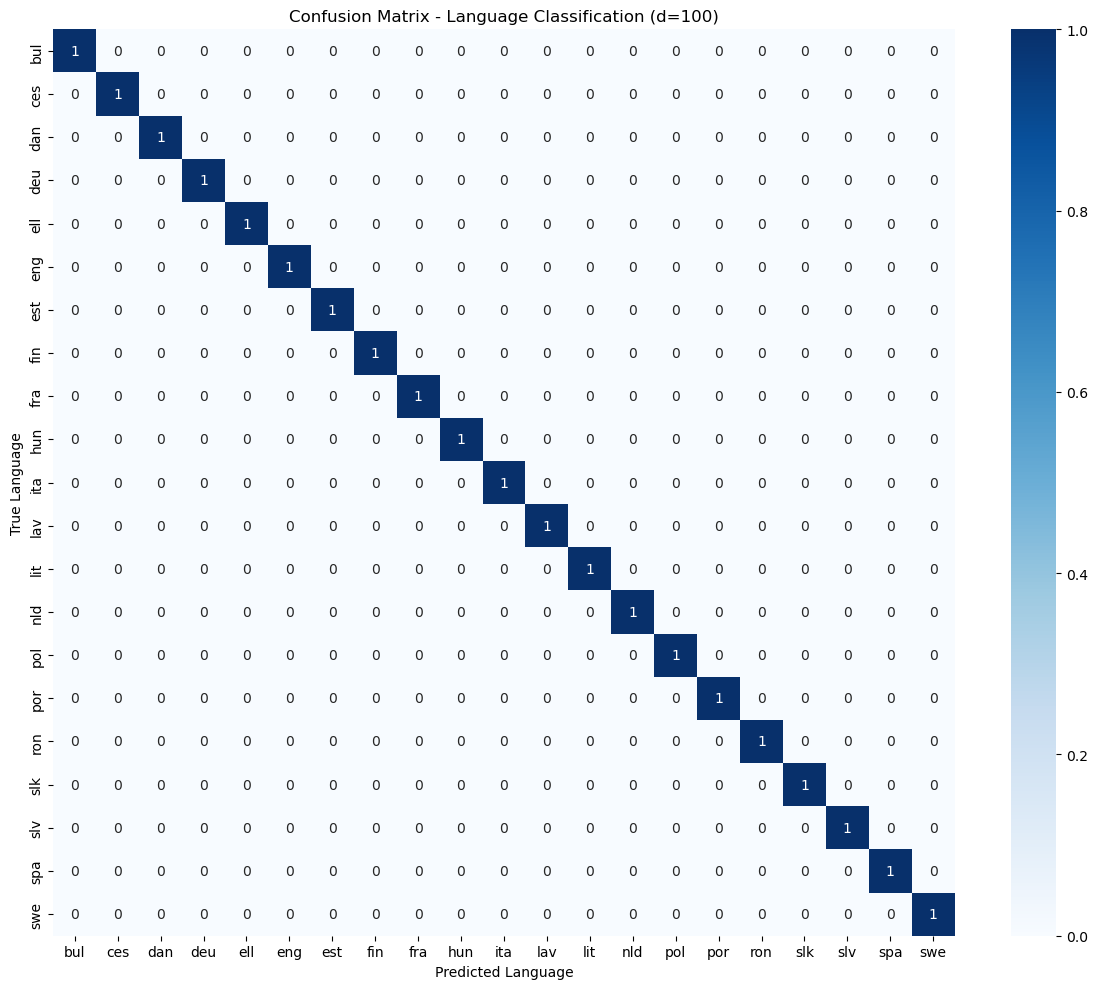

Evaluating with d=1000

Evaluating on Validation set...
  ✓ bul -> bul
  ✓ ces -> ces
  ✓ dan -> dan
  ✓ deu -> deu
  ✓ ell -> ell
  ✓ eng -> eng
  ✓ est -> est
  ✓ fin -> fin
  ✓ fra -> fra
  ✓ hun -> hun
  ✓ ita -> ita
  ✓ lav -> lav
  ✓ lit -> lit
  ✓ nld -> nld
  ✓ pol -> pol
  ✓ por -> por
  ✓ ron -> ron
  ✓ slk -> slk
  ✓ slv -> slv
  ✓ spa -> spa
  ✓ swe -> swe
Results with d=1000:
Accuracy: 1.0000 (100.00%)
F1-Score: 1.0000


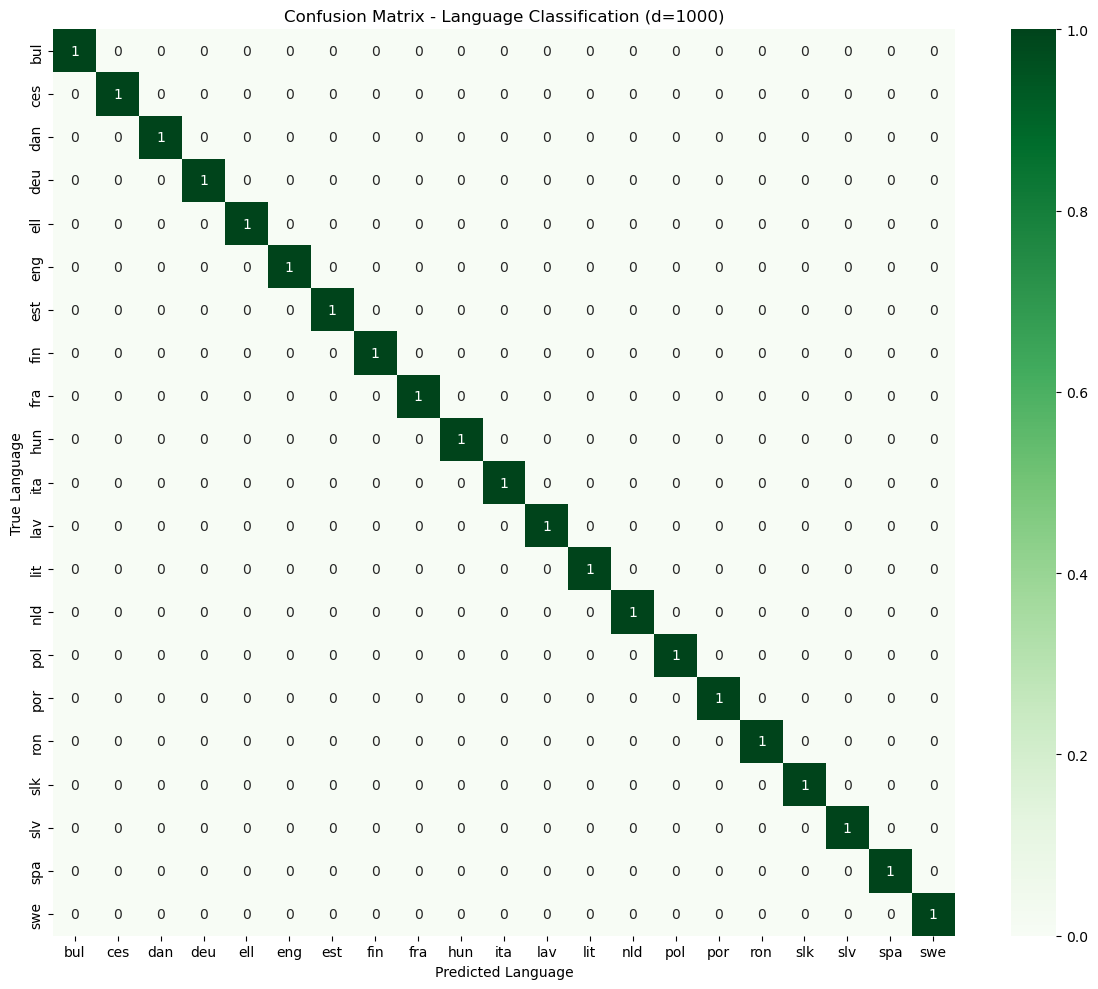

COMPARISON: d=100 vs d=1000
d=100  -> Accuracy: 100.00% | F1-Score: 1.0000
d=1000 -> Accuracy: 100.00% | F1-Score: 1.0000


In [ ]:


print("TASK 1.3: Classification with HD Centroids")

# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    # Dot product of vectors
    dot_product = np.dot(vec1, vec2)
    
    # Magnitude (length) of each vector
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)
    
    # Cosine similarity = dot product / (magnitude1 * magnitude2)
    if magnitude1 == 0 or magnitude2 == 0:
        return 0
    
    similarity = dot_product / (magnitude1 * magnitude2)
    return similarity

# Test it
vec1 = np.array([1, 2, 3])
vec2 = np.array([1, 2, 2])
print(f"Example cosine similarity: {cosine_similarity(vec1, vec2):.4f}")


# Function to classify a text sample
def classify_text(text, language_centroids, trigram_dict):
    """Classify text by finding most similar language centroid"""
    
    # Convert text to HD vector
    query_vector = text_to_hd_vector(text, trigram_dict)
    
    # Compare to all language centroids
    similarities = {}
    for language, centroid in language_centroids.items():
        sim = cosine_similarity(query_vector, centroid)
        similarities[language] = sim
    
    # Find language with highest similarity
    predicted_language = max(similarities, key=similarities.get)
    
    return predicted_language, similarities

# Test with a sample
test_sample = list(val_data.values())[0][:200]  # First language, 200 chars
pred_lang, sims = classify_text(test_sample, centroids_100, trigram_dict_100)
print(f"\nTest classification: Predicted = {pred_lang}")
print(f"Top 3 similarities: {sorted(sims.items(), key=lambda x: x[1], reverse=True)[:3]}")
# Function to evaluate classifier on a dataset


def evaluate_classifier(data_dict, language_centroids, trigram_dict, dataset_name="Test"):
    """Evaluate classifier and return predictions and true labels"""
    
    true_labels = []
    predictions = []
    
    print(f"\nEvaluating on {dataset_name} set...")
    
    for true_language, text in data_dict.items():
        # Classify the text
        predicted_language, _ = classify_text(text, language_centroids, trigram_dict)
        
        # Store results
        true_labels.append(true_language)
        predictions.append(predicted_language)
        
        # Show progress
        match = "✓" if true_language == predicted_language else "✗"
        print(f"  {match} {true_language} -> {predicted_language}")
    
    return true_labels, predictions

# Evaluate on validation set with d=100

print("Evaluating with d=100")
print("="*60)
true_val, pred_val_100 = evaluate_classifier(val_data, centroids_100, trigram_dict_100, "Validation")
# Calculate accuracy
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

accuracy_100 = accuracy_score(true_val, pred_val_100)
f1_100 = f1_score(true_val, pred_val_100, average='weighted')


print(f"Results with d=100:")
print(f"{'='*60}")
print(f"Accuracy: {accuracy_100:.4f} ({accuracy_100*100:.2f}%)")
print(f"F1-Score: {f1_100:.4f}")

# Create confusion matrix
conf_matrix_100 = confusion_matrix(true_val, pred_val_100, labels=sorted(list(val_data.keys())))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_100, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(list(val_data.keys())),
            yticklabels=sorted(list(val_data.keys())))
plt.title('Confusion Matrix - Language Classification (d=100)')
plt.ylabel('True Language')
plt.xlabel('Predicted Language')
plt.tight_layout()
plt.show()


# Now evaluate with d=1000
print("")
print("Evaluating with d=1000")
print("="*60)
true_val, pred_val_1000 = evaluate_classifier(val_data, centroids_1000, trigram_dict_1000, "Validation")

accuracy_1000 = accuracy_score(true_val, pred_val_1000)
f1_1000 = f1_score(true_val, pred_val_1000, average='weighted')

print("")
print(f"Results with d=1000:")
print(f"{'='*60}")
print(f"Accuracy: {accuracy_1000:.4f} ({accuracy_1000*100:.2f}%)")
print(f"F1-Score: {f1_1000:.4f}")

# Plot confusion matrix for d=1000
conf_matrix_1000 = confusion_matrix(true_val, pred_val_1000, labels=sorted(list(val_data.keys())))

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_1000, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted(list(val_data.keys())),
            yticklabels=sorted(list(val_data.keys())))
plt.title('Confusion Matrix - Language Classification (d=1000)')
plt.ylabel('True Language')
plt.xlabel('Predicted Language')
plt.tight_layout()
plt.show()


# Compare 
print("")
print("COMPARISON: d=100 vs d=1000")
print("="*60)

print(f"d=100  -> Accuracy: {accuracy_100*100:.2f}% | F1-Score: {f1_100:.4f}")
print(f"d=1000 -> Accuracy: {accuracy_1000*100:.2f}% | F1-Score: {f1_1000:.4f}")



In [ ]:
### Part 1 Results: HD Language Classification

"""
Task 1.2 Questions
Question 1: What will be the size of the n-gram input vector in conventional (local) representation?

Answer: The size depends on how many unique tri-grams exist in the data. In my dataset, I found 40,121 unique tri-grams across all 21 languages. In conventional one-hot encoding, we need one dimension for each possible tri-gram, so the vector size would be 40,121 dimensions. For example, if a text contains the tri-gram "cat", the vector would be:
[0, 0, 0, ..., 1, ..., 0, 0, 0]  (40,121 total values, only one is 1 "cat" position)            
This is extremely large compared to the 100 or 1000 dimensions used in HD representation.

Question 2: Identify difficulties of working with conventional representations of n-grams in the machine learning context.

Answer: Several problems come up when using conventional n-gram representations:

1.Very high dimensionality: With 40,121 unique tri-grams, we need 40,121-dimensional vectors. This makes everything slow - matrix operations, training, and classification all take much longer.
2.Sparse vectors: Most values in the vector are zeros. If a text only has 100 tri-grams, then only 100 out of 40,121 positions have a value of 1. The rest are wasted zeros. This wastes memory and computation.
3.Scalability issues: If we see new tri-grams (like adding more languages or more text), the dimension keeps growing. There's no fixed size.
4.No similarity between related tri-grams: In one-hot encoding, e.g. "tar" and "rat" are completely different vectors even though they're similar. The model can't learn that similar tri-grams might behave similarly.
5.Memory problems: Storing and processing 40,121-dimensional vectors for thousands of text samples uses a lot of RAM and is inefficient.
The HD approach solves these problems by using fixed, small dimensions (100 or 1000) that don't grow with vocabulary size, and the vectors are dense (no wasted zeros).



"""

In [ ]:
# TODO:

"""
Implement cosine similarity
Classify text samples
Display confusion matrix
Calculate accuracy and F1-score

"""

### Part 2: Unsupervised Learning with Self-Organizing 



#### Task 2.1: Unsupervised Learning of Hand-Written Digits with SOM



In [ ]:
# TODO: Copy SOM code from D7041E-lab4_SOM.ipynb
# TODO: Adapt code to use MNIST instead of zoo.txt

"""
# Step 1: Load the MNIST dataset
# TODO: Load MNIST

# Step 2: Use the flattened (1D) array of pixels of each image as a feature vector
# TODO: Flatten images to 784 features

# Step 3: Initialize weights in SOM network randomly, train SOM with grid sizes
# TODO: Train SOM with grid 20x20
# TODO: Train SOM with grid 40x40
# TODO: Train SOM with grid 80x80

# Step 4: Display initial, intermediate (at 50%), and final learned weights
# TODO: Display initial weights as 28x28 images
# TODO: Display intermediate weights (at 50% of iterations) as 28x28 images
# TODO: Display final learned weights as 28x28 images

# Step 5: Assign labels to neurons by passing TRAINING examples through trained SOM
# TODO: Pass training examples and record statistics
# TODO: Assign labels to neurons
# TODO: Display confusion matrix for TRAINING SET
# TODO: Display confusion matrix for TEST SET

# Step 6: Experiment with learning rate
# TODO: Increase learning rate (fixed iterations)
# TODO: Decrease learning rate (fixed iterations)
# TODO: Answer: What is the resulting effect?


## Question 6: What is the resulting effect of changing learning rate? Answer: [YOUR ANSWER HERE]

# Step 7: Experiment with neighborhood decay
# TODO: For fixed iterations and best learning rate, increase exponential decay of neighbourhood parameter
# TODO: For fixed iterations and best learning rate, decrease exponential decay of neighbourhood parameter


## Question 8: What is the effect? Answer: [YOUR ANSWER HERE] 
## Question 9: What is a biological neuron? How does it relate to the concept of neurons in SOM? Answer: [YOUR ANSWER HERE]

"""

### Part 3: Fundamentals of Artificial Neural Networks and Backpropagation

#### Task 3.1: Multi-layer perceptron and backpropagation


In [ ]:
# TODO: Copy backpropagation code from ANN_backprop.ipynb


### Task 3.1.1: Understand the implementation structure of the multilayer 
"""
Task 3.1.a: Be able to explain the principle of backpropagation algorithm Answer: [YOUR ANSWER HERE] 
Task 3.1.b: Be able to explain the meaning and the role of the Softmax function Answer: [YOUR ANSWER HERE] 
Task 3.1.c: Be able to name typically used non-linear output functions and implications of choosing one or another for implementation Answer: [YOUR ANSWER HERE] 
Task 3.1.d: Find the places in the code where execution breaks, answer the questions, comment out the exit line
# TODO: Find Question 1 in backpropagate() method
# TODO: Answer Question 1: What is computed in the next line of code?


Question 1: What is computed in the delta calculation? Answer: [YOUR ANSWER HERE]
# TODO: Comment out exit_with_err() for Question 1
# TODO: Find Question 2 in backpropagate() method
# TODO: Answer Question 2: What does this 'for' loop do?

Question 2: What does the backpropagation 'for' loop do? Answer: [YOUR ANSWER HERE]
# TODO: Comment out exit_with_err() for Question 2
# TODO: Find Question 3 in evaluate() method
# TODO: Answer Question 3: How is weight update implemented? What is eta?

Question 3: How is weight update implemented? What is eta? Answer: [YOUR ANSWER HERE]
# TODO: Comment out exit_with_err() for Question 3

"""

In [ ]:
## Task 3.1.2: Run with default hyperparameters
# TODO: Run with epochs=70, learning_rate=0.05
# TODO: Record classification 

"""
Question: What is the classification accuracy? Answer: [YOUR ANSWER HERE]

"""

In [ ]:
## Task 3.1.3: Run with different learning rates
# TODO: Run with learning_rate=0.005
# TODO: Run with learning_rate=0.5
# TODO: Compare results
"""
Question: Explain the observed differences in the functionality of the multi-layer perceptron Answer: [YOUR ANSWER HERE] 

"""

In [ ]:
## Task 3.1.4: Implement ReLU activation function
# TODO: Implement f_relu() function with forward pass
# TODO: Implement f_relu() derivative
# TODO: Run perceptron with ReLU, epochs=70, learning_rate=0.05
# TODO: Record classification accuracy with ReLU
# TODO: Find learning rate values that give comparable accuracy to Sigmoid

"""
Question: What is the classification accuracy with ReLU? Answer: [YOUR ANSWER HERE] Question: What learning rate gives comparable accuracy to Sigmoid? Answer: [YOUR ANSWER HERE]

"""